# Job Candidate Suitability Prediction Model

by Michael Savin

# 0. Importing

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from IPython.display import Image

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, auc, roc_auc_score, mean_squared_error, roc_curve, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from wordcloud import WordCloud

# 1. Exploration



Head of data:

       ID worked_in_the_past age_group disability         is_dev education  \
0  65168                  T     young         No      developer       NaN   
1  38314                  T     young         No  non-developer     other   
2   5209                  T       old         No      developer     other   
3  54165                  T     young        NaN      developer     other   
4  42213                  T     young         No      developer    BA/BSc   

    sex mental_issues  years_of_experience          A     B    C           D  \
0  Male            No                 13.0  -1.093080   1.0   aa  180.984266   
1  Male           Yes                  7.0   5.444533   7.0  rhz  180.677533   
2  Male           Yes                 25.0   1.727255  15.0   aa  177.746162   
3  Male            No                 10.0  17.804302   7.0   aa  176.952584   
4  Male            No                 12.0  -8.679091   4.0   hr  179.393259   

                    country  prev_sala

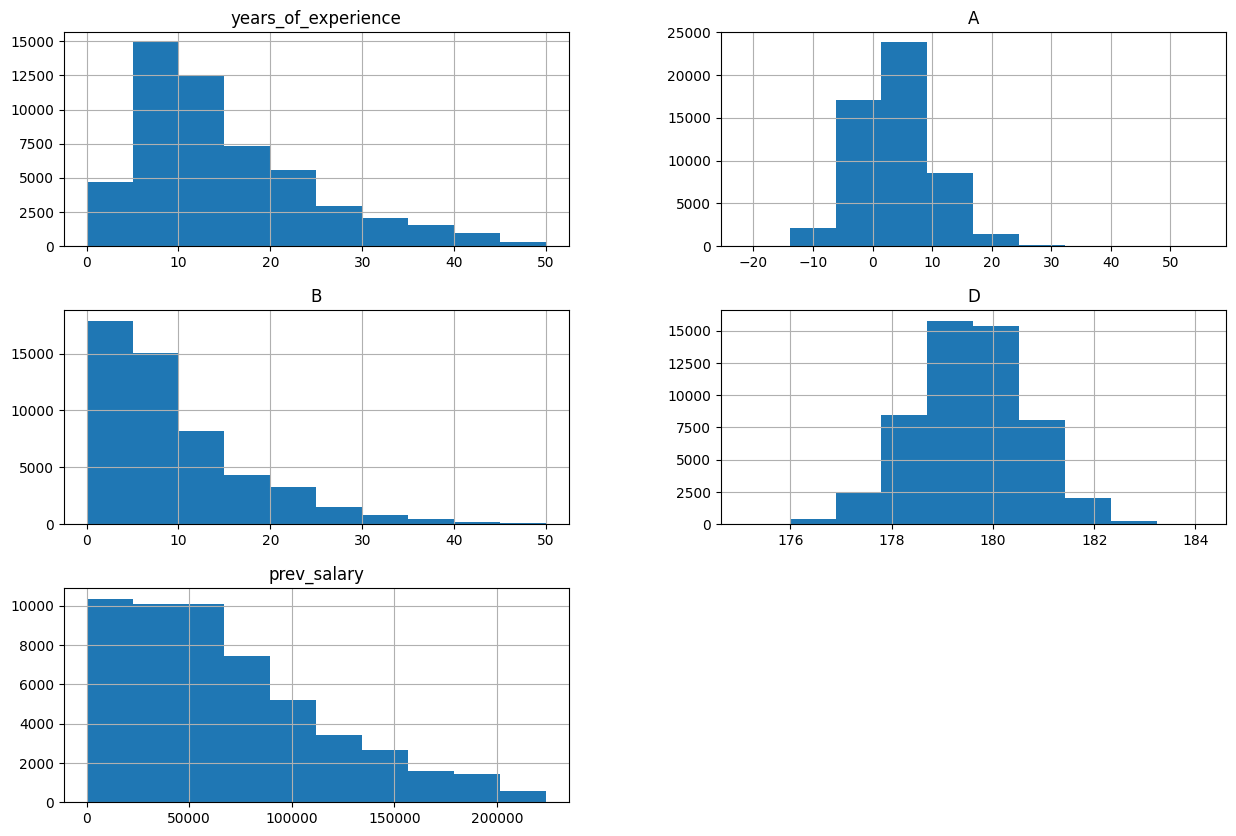



Boxplots of data:




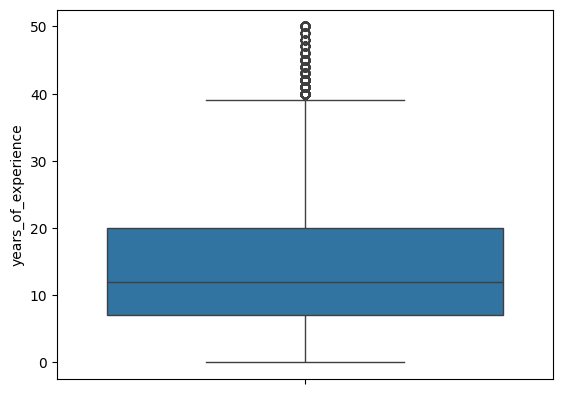

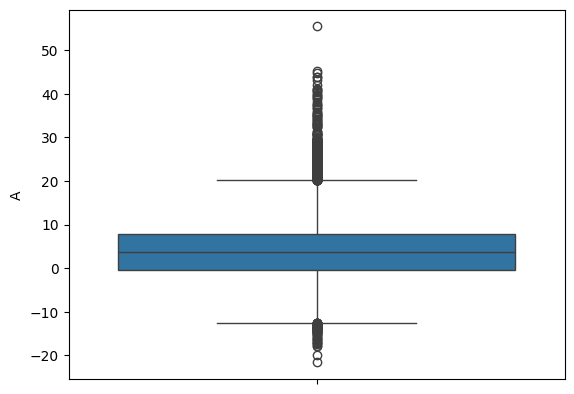

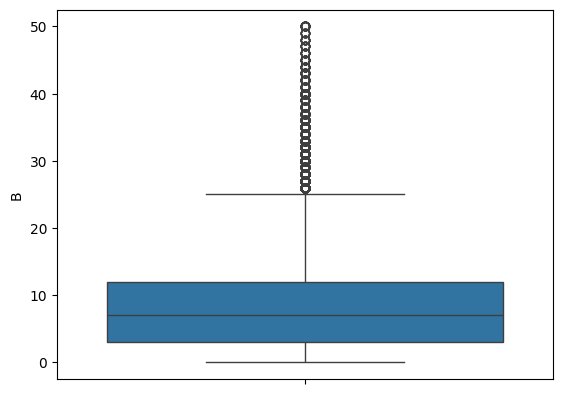

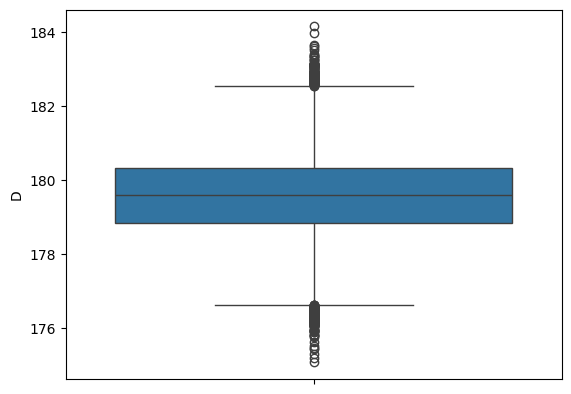

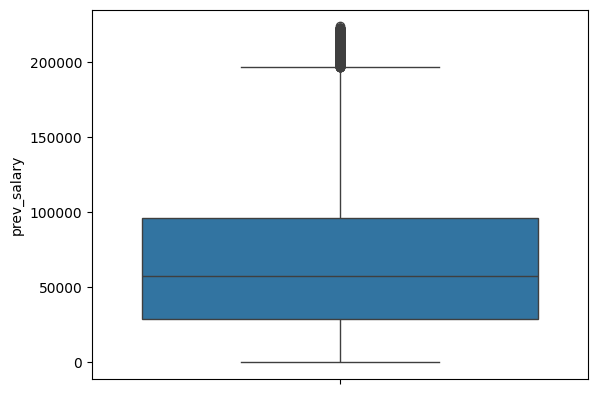



Relationships between features:




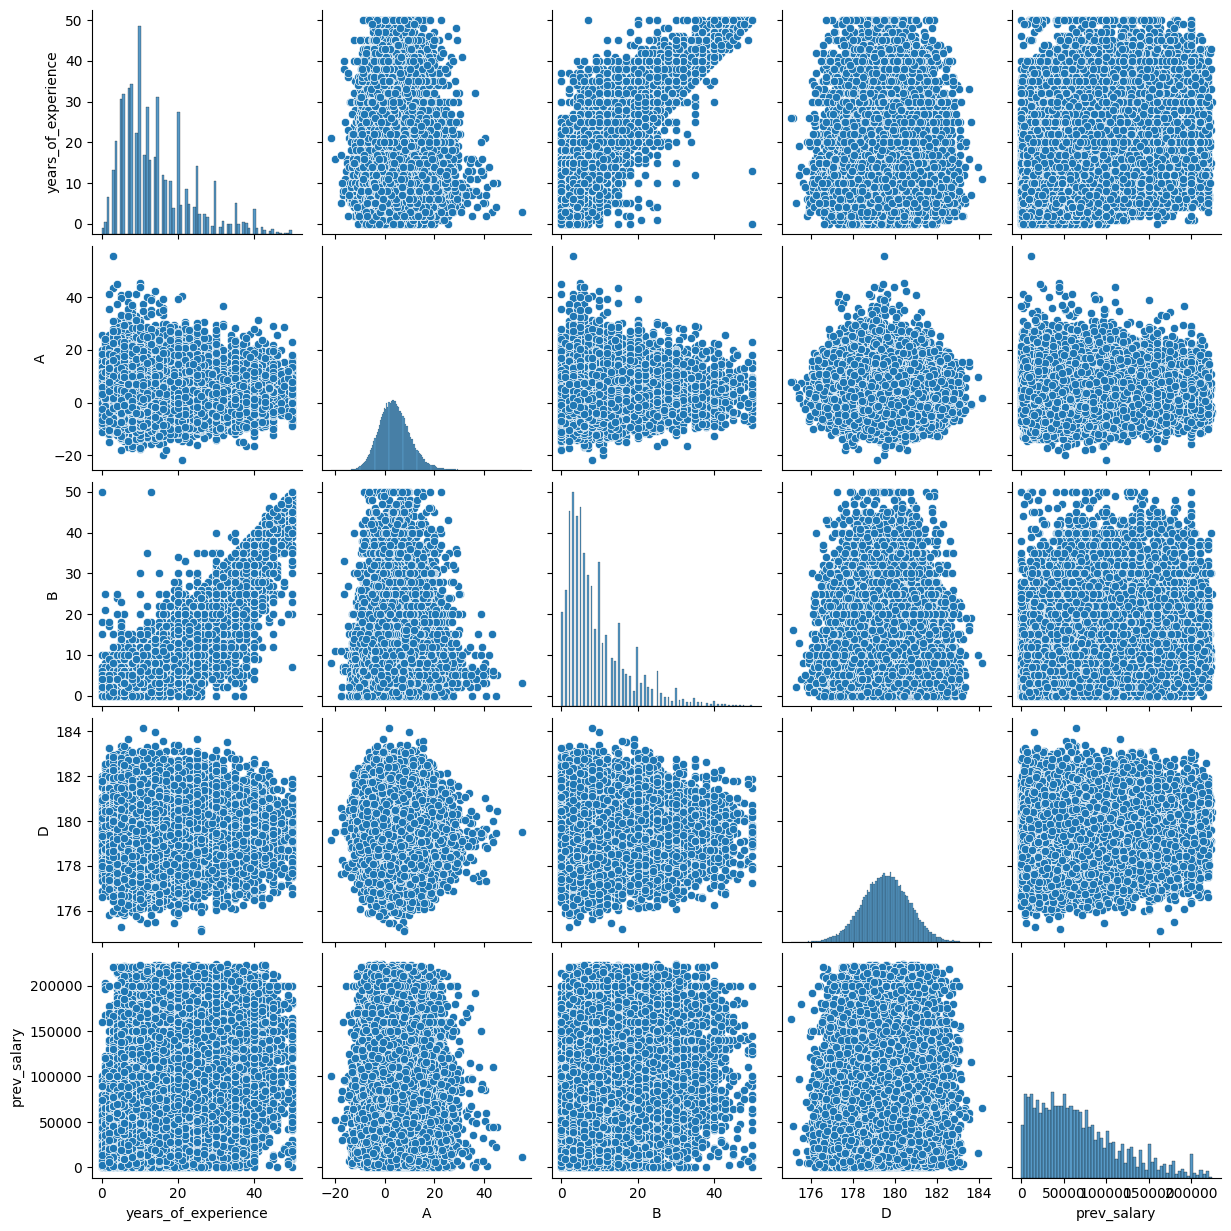



Relationships between features heatmap




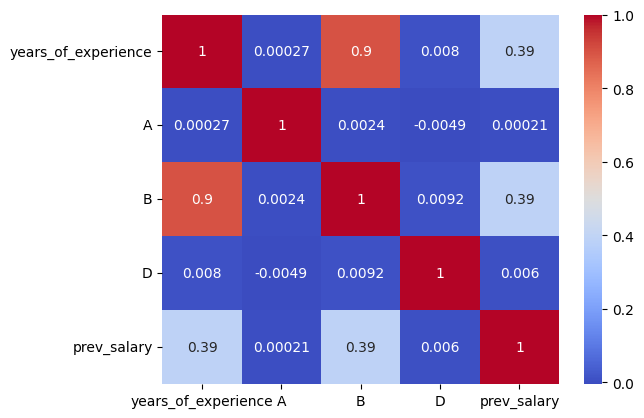

worked_in_the_past
T    47361
F     6336
Name: count, dtype: int64
age_group
young    34545
old      18377
Name: count, dtype: int64
disability
No     50281
Yes     1500
Name: count, dtype: int64
is_dev
developer        49055
non-developer     4317
Name: count, dtype: int64
education
BA/BSc         26693
MA/MSc         13503
other           7757
High school     2634
Phd             1859
Name: count, dtype: int64
sex
Male      48777
Female     2490
Other       967
Name: count, dtype: int64
mental_issues
No     41107
Yes    11940
Name: count, dtype: int64
C
aa     21082
ww     10215
hr      7850
rhz     5223
br      4882
mn      2632
ca       576
Name: count, dtype: int64
country
United States of America                                10690
Germany                                                  3967
India                                                    3891
United Kingdom of Great Britain and Northern Ireland     3462
Canada                                                   1988
   

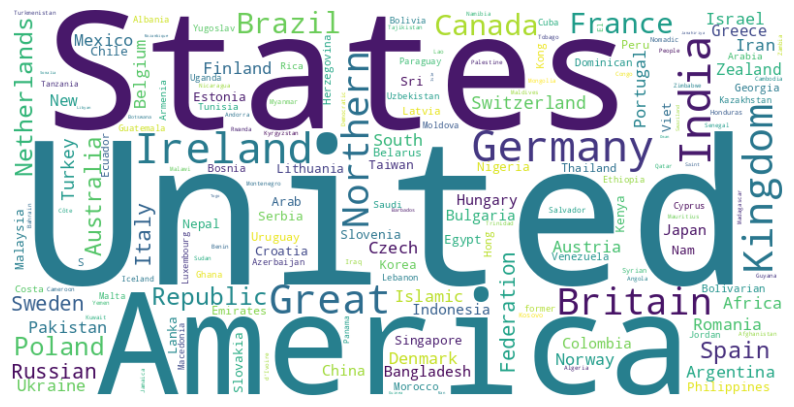

In [ ]:
data = pd.read_csv('train.csv')

all_cols = data.columns
columns_to_exclude = ['ID', 'label']  # Example columns you might want to exclude

# Drop the specified columns for exploration
data_filtered = data.drop(columns=columns_to_exclude)

# Seperate numeric and categorial columns for exploration
numeric_cols = data_filtered.select_dtypes(include=np.number).columns
numeric_data = data_filtered[numeric_cols]
categorical_cols= list(set(all_cols) - set(numeric_cols))

#Head
print("\n\nHead of data:\n\n", data.head())

#Shape
print("\n\nShape of data:\n\n", data.shape)

# Statistics
print("\n\nStatistics of data:\n\n", data.describe())

print("\n\nGraphs:\n\n")

# Graphs
# Histogram
print("\n\nHistogram of data:\n\n")
data_filtered.hist(figsize=(15, 10)) #bins=30
plt.show()

# Check outliers
print("\n\nBoxplots of data:\n\n")
for col in data_filtered.select_dtypes(include=['number']).columns:
    sns.boxplot(data_filtered[col])
    plt.show()

# Relationships between features
print("\n\nRelationships between features:\n\n")
sns.pairplot(data_filtered)
plt.show()

# Relationships between features in a heatmap
print("\n\nRelationships between features heatmap\n\n")
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# Define a function to handle missing values
def handle_missing_data(df):
    # Strategy for each column can be customized based on data type and context
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if col in categorical_cols:
                # For categorical data, fill with mode
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                # For numerical data, fill with mean
                df[col].fillna(df[col].mean(), inplace=True)
    return df

for col in data.select_dtypes(include=['object']).columns:
    print(data[col].value_counts())

# Handling missing data for wordCloud
data = handle_missing_data(data)

text_data = data['country']
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations= False).generate(' '.join(text_data))

plt.figure(figsize=(10,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


Visualization analysis
We started by making visualizations mainly for numerical variables because the exploration phase came before treating categorical variables. Let's start with the histograms.

The histograms show a concentration of candidates around certain sizes:
Years_of_experience - the histogram shows that most candidates have between 5-10 years of experience and that after 10 years of experience the number of candidates in each 5-year range decreases.
A - Most of the data is concentrated between 5 and 15 with the larger group being between 2-8.
B - The largest concentration of candidates between 0-5 and decreases in each subsequent range.
D - concentration in the middle between 179-181 and decay at the edges.
Prev_salary – Most candidates received a previous salary of between 0-20000, with another large concentration between 20000-60000, declining from there.

Box plots:
The Boxplots are good at showing outliers:
years_of_experience – there are a few outliers over 40.
A - There is a very high number of outliers above 20 and below 12-.
B – a high number of outliers over 25.
D - a very high number above 185, and below 177.
prev_salary – a very high number over 200,000.

Relationship between features heatmap:
A graph that shows us correlation between features.
There is a high correlation between certain features and a complete lack of correlation between others.
For example, between variable B and years_of_experience there is a correlation of 0.9. This is a very high correlation!
Between years_of_experience and prev_salary there is a correlation of 0.39, a relatively high correlation.
In contrast, years_of_experience and A we see a correlation of 0.00027 - a complete lack of correlation.

Wordmap:
Whows the dominance of certain countries as the countries of origin of the candidates.
The most prominent country is the USA.
Other notable countries are Germany, India, Ireland, the United Kingdom, Canada.


# 2. Preprocessing

# a) Outliers
We'll use box plots for years_of_experience, A, B, D, and prev_salary to visually identify outliers in these columns.
We notice that there are outliers and we're going to identify them and remove them.

In [ ]:
# Outliers
def deal_with_outliers(data):
    # Identifying outliers for each numerical column
    def identify_outliers(data, columns):
        outliers = pd.DataFrame()
        for col in columns:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers[col] = ((data[col] < lower_bound) | (data[col] > upper_bound))
        return outliers

    def remove_outliers(data, outliers):
        for col in outliers.columns:
            data = data[~outliers[col]]
        return data

    outliers = identify_outliers(data, numeric_cols)

    # Count of outliers for each column
    outlier_counts = {col: len(outliers[col]) for col in outliers}

    data_no_outliers = remove_outliers(data.copy(), outliers)

    return data_no_outliers

data = deal_with_outliers(data)

<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]
<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]
<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]
<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]


# b) Normalization
First we check for normalization by examining the range and distribution of the numerical columns.
The data is not normalized, we will aplly a min-max transformation.
The importance of normaliztion here is that it enables us to compare and correlate features, being on the same scale from 0 to 1.

In [ ]:
# Normalization
def data_normalization(data):
    # Checking the range of numerical columns
    data_ranges = data[numeric_cols].describe().loc[['min', 'max']]
    print("Ranges of numerical columns before normalization:")
    print(data_ranges)

    # Function to normalize the data
    def normalize_data(data, cols):
        scaler = MinMaxScaler()
        data[cols] = scaler.fit_transform(data[cols])
        return data


    print("Data needs normalization. Applying min-max scaling...")
    data = normalize_data(data, numeric_cols)
    data_ranges = data[numeric_cols].describe().loc[['min', 'max']]
    print("Ranges of numerical columns after normalization:")
    print(data_ranges)
    return data

# Function to normalize the data
def normalize_data_categorial(data):
    cols = ["country", "education"]
    scaler = MinMaxScaler()
    data[cols] = scaler.fit_transform(data[cols])
    return data

data = data_normalization(data)

Ranges of numerical columns before normalization:
     years_of_experience          A     B           D  prev_salary
min                  0.0 -11.907392   0.0  176.794493          1.0
max                 37.0  19.418547  24.0  182.375120     187000.0
Data needs normalization. Applying min-max scaling...
Ranges of numerical columns after normalization:
     years_of_experience    A    B    D  prev_salary
min                  0.0  0.0  0.0  0.0          0.0
max                  1.0  1.0  1.0  1.0          1.0


# c) Missing values
- There are missing values in the data. For categorical columns, missing values are filled with the most frequent value.
For numerical columns, missing values are filled with the mean.

In [ ]:
# Missing values
# Check for missing values
missing_data = data.isnull().sum()

# Define a function to handle missing values
def handle_missing_data(df):
    # Strategy for each column can be customized based on data type and context
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if col in categorical_cols:
                # For categorical data, fill with mode
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                # For numerical data, fill with mean
                df[col].fillna(df[col].mean(), inplace=True)
    return df

# Number of rows with at least one missing value
rows_with_missing = data.isnull().any(axis=1).sum()

# Display the count
print(f"Number of rows with at least one missing value: {rows_with_missing}")

# Handling missing data
data = handle_missing_data(data)
# Verify if all missing data is handled
missing_data_after = data.isnull().sum()
print("Missing data count after handling:", missing_data_after)
print(missing_data_after[missing_data_after > 0])

Number of rows with at least one missing value: 0
Missing data count after handling: ID                     0
worked_in_the_past     0
age_group              0
disability             0
is_dev                 0
education              0
sex                    0
mental_issues          0
years_of_experience    0
A                      0
B                      0
C                      0
D                      0
country                0
prev_salary            0
stack_experience       0
label                  0
dtype: int64
Series([], dtype: int64)


# d) Categorial variables
 - These need to be processed in a way that can be provided to machine learning algorithms. We have a few options:
Binary Encoding: Converts categories into binary digits.
Label Encoding: Converts categorical values into numerical labels. Useful for ordinal variables where the order matters.
One-Hot Encoding: Creates binary columns for each category. Useful for nominal variables where the order doesn't matter.

Our categorial variables are: worked_in_the_past, age_group, disability, is_dev, education, sex, mental_issues, country, stack_experience.

'education', 'country' and 'stack_experience' are the only categorial variables that aren't binary.

We will use binary encoding for the rest.

In [ ]:
def handle_categorial_variables(data):
    education_ordering = {'other': 0, 'High school': 1, 'BA/BSc': 2, 'MA/MSc': 3, 'Phd': 4 }
    data['education'] = data['education'].map(education_ordering)

    # Handle binary columns
    data['disability'] = data['disability'].apply(lambda x: 1 if x.lower() == 'yes' else 0)
    data['is_dev'] = data['is_dev'].apply(lambda x: 1 if x.lower() == 'developer' else 0)
    data['sex'] = data['sex'].apply(lambda x:1 if x.lower() == 'male' else 0)
    data['mental_issues'] = data['mental_issues'].apply(lambda x: 1 if x.lower() == 'yes' else 0)
    data['worked_in_the_past'] = data['worked_in_the_past'].apply(lambda x: 1 if x.lower() == 't' else 0)
    data['age_group'] = data['age_group'].apply(lambda x: 1 if x.lower() == 'young' else 0) # 1 if "young" 0 if "old"

    # Handle Country column
    frequency_map = data['country'].value_counts().to_dict()
    data['country'] = data['country'].map(frequency_map)

    data =  normalize_data_categorial(data)

    # Get the unique values in the 'C' column
    unique_values_in_C = data['C'].unique()

    # Create a new binary column for each unique value in 'C'
    for value in unique_values_in_C:
        data[f'{value}'] = data['C'].apply(lambda x: 1 if x == value else 0)

    # Drop the original 'C' column
    data = data.drop(columns=['C'])

    #Handle stack_experience
    languages = set()

    # Split each entry by ';' and add to the set
    data['stack_experience'].dropna().apply(lambda x: languages.update(x.split(';')))

    # Convert the set to a sorted list for consistent column ordering
    languages = sorted( languages)

    # Create a new DataFrame with one column for each language
    for language in languages:
        data[language] = data['stack_experience'].apply(lambda x: 1 if language in x.split(';') else 0)

    # Drop the original 'stack_experience' column
    data = data.drop(columns=['stack_experience'])

    # Sum the values in each column to get the count of '1's
    language_counts = data[languages].sum().sort_values(ascending=False)

    # Select the top 40 languages
    top_40_languages = language_counts.head(40).index

    # Keep only the top 40 language columns
    data = data[ [ 'worked_in_the_past', 'age_group', 'disability', 'is_dev', 'education', 'sex', 'mental_issues', 'years_of_experience', 'A', 'B'] + list(unique_values_in_C) +[ 'D', 'country', 'prev_salary']  + list(top_40_languages) + ['label']]
    # data = data[ [ 'worked_in_the_past', 'age_group', 'disability', 'is_dev', 'education', 'sex', 'mental_issues', 'years_of_experience', 'A', 'B',] +  list(encoded_df.columns) + [ 'D', 'country', 'prev_salary', 'label'] + list(top_40_languages)]
    return data

data = handle_categorial_variables(data)
data.to_csv('after.csv', index=False)

def handle_categorial_variables_test(data):
    education_ordering = {'other': 0, 'High school': 1, 'BA/BSc': 2, 'MA/MSc': 3, 'Phd': 4 }
    data['education'] = data['education'].map(education_ordering)

    # Handle binary columns
    data['disability'] = data['disability'].apply(lambda x: 1 if x.lower() == 'yes' else 0)
    data['is_dev'] = data['is_dev'].apply(lambda x: 1 if x.lower() == 'developer' else 0)
    data['sex'] = data['sex'].apply(lambda x:1 if x.lower() == 'male' else 0)
    data['mental_issues'] = data['mental_issues'].apply(lambda x: 1 if x.lower() == 'yes' else 0)
    data['worked_in_the_past'] = data['worked_in_the_past'].apply(lambda x: 1 if x.lower() == 't' else 0)
    data['age_group'] = data['age_group'].apply(lambda x: 1 if x.lower() == 'young' else 0) # 1 if "young" 0 if "old"

    # Handle Country column
    frequency_map = data['country'].value_counts().to_dict()
    data['country'] = data['country'].map(frequency_map)

    # Get the unique values in the 'C' column
    unique_values_in_C = data['C'].unique()
    # Create a new binary column for each unique value in 'C'
    for value in unique_values_in_C:
        data[f'{value}'] = data['C'].apply(lambda x: 1 if x == value else 0)

    # Drop the original 'C' column
    data = data.drop(columns=['C'])

    #Handle stack_experience
    languages = set()

    # Split each entry by ';' and add to the set
    data['stack_experience'].dropna().apply(lambda x: languages.update(x.split(';')))

    # Convert the set to a sorted list for consistent column ordering
    languages = sorted( languages)

    # Create a new DataFrame with one column for each language
    for language in languages:
        data[language] = data['stack_experience'].apply(lambda x: 1 if language in x.split(';') else 0)

    # Drop the original 'stack_experience' column
    data = data.drop(columns=['stack_experience'])

    # Sum the values in each column to get the count of '1's
    language_counts = data[languages].sum().sort_values(ascending=False)

    # Select the top 40 languages
    top_40_languages = language_counts.head(40).index

    # Keep only the top 40 language columns
    test_ids = data['ID']
    data = data[ ['worked_in_the_past', 'age_group', 'disability', 'is_dev', 'education', 'sex', 'mental_issues', 'years_of_experience', 'A', 'B'] +  list(unique_values_in_C) + ['D', 'country', 'prev_salary'] + list(top_40_languages)]
    return data, test_ids


<ipython-input-7-c11090b9fc5c>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[language] = data['stack_experience'].apply(lambda x: 1 if language in x.split(';') else 0)
<ipython-input-7-c11090b9fc5c>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[language] = data['stack_experience'].apply(lambda x: 1 if language in x.split(';') else 0)
<ipython-input-7-c11090b9fc5c>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

# e) Dimensionality
 - High dimensionality in a dataset can create problems,such as overfitting (High-dimensional data can lead to models that capture noise instead of the underlying pattern, causing poor generalization to new data),increased computational cost ( More dimensions require more computational resources for training and inference) , sparse data ( higher probability of a non full row).
- Our dimensionality here is indeed too high as we can get very close accuracy after reducing from 60 variables to 48 using PCA
- Reducing the number of variables will improve performance speeds

In [ ]:
X = data.to_numpy()
X = X[:, :-1]
y = data['label'].to_numpy()

def dimensionality_and_pca(X):
    # Dimensionality
    # Check the number of features

    num_features = X.shape[1]
    print(f"Number of features: {num_features}")

    # Scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=0.95)  # Retain 95% of the variance
    X_train_pca = pca.fit_transform(X_train_scaled)

    # Check the shape of the data after PCA
    print(f"Original shape: {X_train_scaled.shape}")
    print(f"Reduced shape: {X_train_pca.shape}")

    print(f"Reduced number of features after PCA: {X_train_pca.shape[1]}")
    return X_train_pca


# def definetly_better_than_pca(data):
#     data_after_variable_drop = data.drop(columns=['country', 'sex', "npm", "Redis", "Yarn", "PHP", "Kubernetes", "Angular", "Express", "ASP.NET Core", "Vue.js", "MariaDB", "Elasticsearch", "Heroku", "Firebase", "ASP.NET",  "DigitalOcean", "PowerShell", "Google Cloud Platform", "Go"])
#     return data_after_variable_drop

# f) Preprocessing on test set

In [ ]:
# Preprocessing function to be applied to the test set
def preprocess_test_set(test_data):
    # Load the test dataset
    test_data = deal_with_outliers(test_data)
    # Normaliation
    test_data = data_normalization(test_data)
    # Handle missing data
    test_data = handle_missing_data(test_data)
    # Handle categorial variables
    test_data, test_ids = handle_categorial_variables_test(test_data)
    # Normalize again after handling categorial variables
    test_data = normalize_data_categorial(test_data)
    # Return processed data and 'ID' column
    return test_data, test_ids

test_data = pd.read_csv('test.csv')
test_data, test_ids = preprocess_test_set(test_data) # Apply preprocessing on test set

# Convert the DataFrame to a NumPy array
X_test = test_data.to_numpy()
# Apply PCA to test set
X_test = dimensionality_and_pca(X_test)

<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]
<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]
<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]
<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]


Ranges of numerical columns before normalization:
     years_of_experience          A     B           D  prev_salary
min                  0.0 -12.634070   0.0  176.590043          1.0
max                 39.0  20.174409  25.0  182.574630     196400.0
Data needs normalization. Applying min-max scaling...
Ranges of numerical columns after normalization:
     years_of_experience    A    B    D  prev_salary
min                  0.0  0.0  0.0  0.0          0.0
max                  1.0  1.0  1.0  1.0          1.0


<ipython-input-7-c11090b9fc5c>:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[language] = data['stack_experience'].apply(lambda x: 1 if language in x.split(';') else 0)
<ipython-input-7-c11090b9fc5c>:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[language] = data['stack_experience'].apply(lambda x: 1 if language in x.split(';') else 0)
<ipython-input-7-c11090b9fc5c>:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

Number of features: 60
Original shape: (16510, 60)
Reduced shape: (16510, 48)
Reduced number of features after PCA: 48


# 3. Models

# a) Logistic Regression
Hyperparamaters are:
- random_state = 10
- max_iter = 1000
- Default values of 'tol' are good enough (1e-4)

In [ ]:
# Logistic Regression
X = dimensionality_and_pca(X)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=len(X_test), random_state=42)

log_reg_model = LogisticRegression(random_state=42)

# Train the model on the training data
log_reg_model.fit(X_train, y_train)

#Predict on the validation set
y_val_pred = log_reg_model.predict(X_val)

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.5f}")

# Predict probabilities for the validation set
y_val_prob = log_reg_model.predict_proba(X_val)[:, 1]

# Calculate the AUC score
auc_log = roc_auc_score(y_val, y_val_prob)
print(f"AUC Score: {auc_log:.5f}")

# Generate a classification report
report = classification_report(y_val, y_val_pred)
print("Classification Report:")
print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_val, y_val_pred)
print("Confusion Matrix:")
print(conf_matrix)

Number of features: 60
Original shape: (49354, 60)
Reduced shape: (49354, 48)
Reduced number of features after PCA: 48
Accuracy: 0.79449
AUC Score: 0.91388
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7585
           1       0.86      0.73      0.79      8925

    accuracy                           0.79     16510
   macro avg       0.80      0.80      0.79     16510
weighted avg       0.81      0.79      0.79     16510

Confusion Matrix:
[[6558 1027]
 [2366 6559]]


# b) K-NN
Hyperparamaters are:
- Neighbors = 7, gave us a good balance of not sacrificing accuracy much
- algorithm = 'auto' chooses the best one
- weights = 'uniform' by default

In [ ]:
# KNN
# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=7)
knn_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_knn = knn_model.predict(X_val)
y_val_prob_knn = knn_model.predict_proba(X_val)[:, 1]

# Evaluate K-Nearest Neighbors
accuracy_knn = accuracy_score(y_val, y_val_pred_knn)
auc_knn = roc_auc_score(y_val, y_val_prob_knn)
print(f"KNN - Accuracy: {accuracy_knn:.5f}, AUC: {auc_knn:.5f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_knn))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_knn))

KNN - Accuracy: 0.78976, AUC: 0.88916
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      7585
           1       0.84      0.75      0.80      8925

    accuracy                           0.79     16510
   macro avg       0.79      0.79      0.79     16510
weighted avg       0.80      0.79      0.79     16510

Confusion Matrix:
[[6301 1284]
 [2187 6738]]


# c) Random forest
Hyperparametrs:
- random_state = 42 - we pick a random number
- n_estimator = since we can afford to compute for longer we choose a higher n_estimator
- max_depth = default

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators = 300)
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_rf = rf_model.predict(X_val)
y_val_prob_rf = rf_model.predict_proba(X_val)[:, 1]

# Evaluate Random Forest
accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
auc_rf = roc_auc_score(y_val, y_val_prob_rf)
print(f"Random Forest - Accuracy: {accuracy_rf:.5f}, AUC: {auc_rf:.5f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_rf))


# # Train the model
# rf_model.fit(X, y)

# # # Predict on the train set
# y_pred = rf_model.predict(X)

# # Evaluate the model
# accuracy = accuracy_score(y, y_pred)
# print(f"Accuracy of the Random Forest model: {accuracy:.4f}")
# print(classification_report(y, y_pred))

# # Predict on the test set
# y_pred = rf_model.predict(X_test)

# # Evaluate the model
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy of the Random Forest model: {accuracy:.4f}")
# print(classification_report(y_test, y_pred))

# rf.fit(X , y)
# y_pred=rf.predict(X)
# sns.scatterplot(y_test,y_pred)
# plt.plot()
# idx=np.argsort(rf.feature_importances_)
# sns.barplot(x=rf.feature_importances_[idx],y=data.columns[:5][idx])
# plt.show()


# rf = RandomForestRegressor(n_estimators=500)
# rf.fit(X , y)
# y_pred=rf.predict(X)
# sns.scatterplot(y_test,y_pred)
# plt.plot()
# idx=np.argsort(rf.feature_importances_)
# sns.barplot(x=rf.feature_importances_[idx],y=data.columns[:5][idx])
# plt.show()

Random Forest - Accuracy: 0.85033, AUC: 0.93214
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      7585
           1       0.85      0.89      0.86      8925

    accuracy                           0.85     16510
   macro avg       0.85      0.85      0.85     16510
weighted avg       0.85      0.85      0.85     16510

Confusion Matrix:
[[6138 1447]
 [1024 7901]]


# d) Adaboost
Hyperparameters are:
- n_estimators: left at default of 50, no reason to improve performance
- learning_rate: again default of 1.0, learning rate fit us well
- random_state: 42. Number doesn't number but important to pick a random state so as to inmprove reproducibility.

In [ ]:
# AdaBoost
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_ada = ada_model.predict(X_val)
y_val_prob_ada = ada_model.predict_proba(X_val)[:, 1]

# Evaluate AdaBoost
accuracy_ada = accuracy_score(y_val, y_val_pred_ada)
auc_ada = roc_auc_score(y_val, y_val_prob_ada)
print(f"AdaBoost - Accuracy: {accuracy_ada:.2f}, AUC: {auc_ada:.2f}")
print("Classification Report:")
print(classification_report(y_val, y_val_pred_ada))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_val_pred_ada))

# ada_model = AdaBoostClassifier(random_state=42)
# ada_model.fit(X, y)
# y_pred_ada = ada_model.predict(X)
# accuracy_ada = accuracy_score(y, y_pred_ada)
# print(f"Adaptive Boosting Training Accuracy: {accuracy_ada}")

AdaBoost - Accuracy: 0.83, AUC: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      7585
           1       0.84      0.83      0.84      8925

    accuracy                           0.83     16510
   macro avg       0.82      0.83      0.83     16510
weighted avg       0.83      0.83      0.83     16510

Confusion Matrix:
[[6219 1366]
 [1505 7420]]


# 4. Model Evaluation

# a) Confusion Matrix
We're getting good amount of True positive and negatives, model is working well.

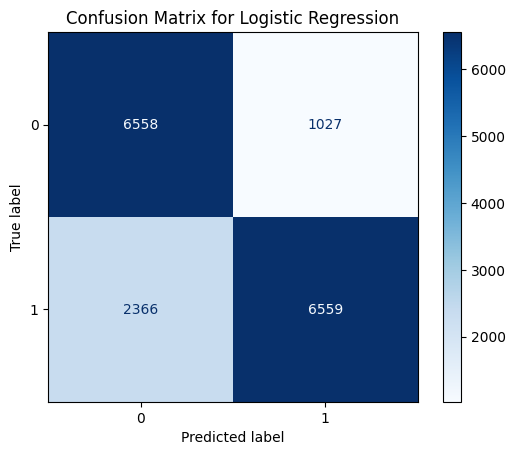

Confusion Matrix:
 [[6558 1027]
 [2366 6559]]


In [ ]:
# Predicting the test set results
y_pred = log_reg_model.predict(X_val)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg_model.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# Printing the confusion matrix
print("Confusion Matrix:\n", conf_matrix)

# b) Cross Fold-K Validation
Building an ROC output on each Fold-K for each of the models run

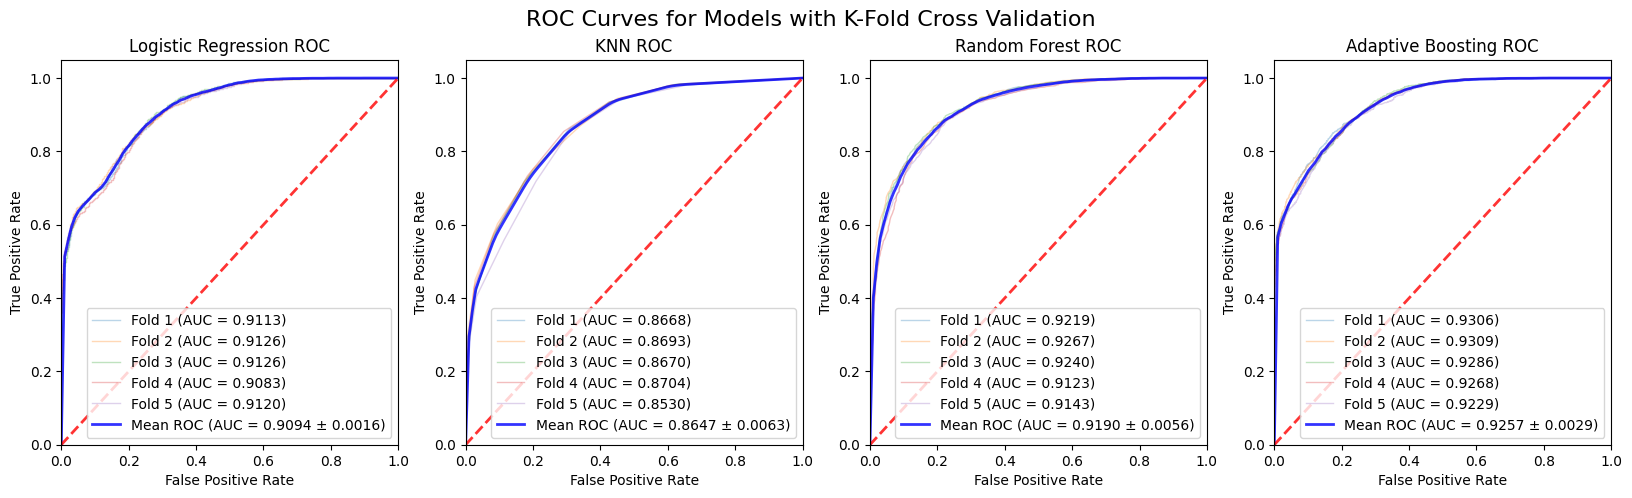

In [ ]:
# Number of splits for K-Fold
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize plots
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

models = {
    'Logistic Regression': log_reg_model,
    'KNN': knn_model,
    'Random Forest': rf_model,
    'Adaptive Boosting': ada_model
}

# Loop over each model
for i, (model_name, model) in enumerate(models.items()):
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []

    # Loop over each fold
    for fold, (train_index, test_index) in enumerate(kf.split(X_val , y_val)):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]

        # Train the model
        model.fit(X_train_fold, y_train_fold)

        # Get the probability estimates for the positive class
        y_prob = model.predict_proba(X_test_fold)[:, 1]

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test_fold, y_prob)
        roc_auc = auc(fpr, tpr)

        # Interpolate the ROC curve to get a mean curve across folds
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)

        # Plot ROC curve for the current fold
        ax[i].plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {fold + 1} (AUC = {roc_auc:.4f})')

    # Plot the mean ROC curve across folds
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax[i].plot(mean_fpr, mean_tpr, color='b',
               label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})',
               lw=2, alpha=0.8)

    # Plot the chance line (diagonal)
    ax[i].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

    ax[i].set_xlim([0.0, 1.0])
    ax[i].set_ylim([0.0, 1.05])
    ax[i].set_xlabel('False Positive Rate')
    ax[i].set_ylabel('True Positive Rate')
    ax[i].set_title(f'{model_name} ROC')
    ax[i].legend(loc='lower right')

plt.suptitle('ROC Curves for Models with K-Fold Cross Validation', fontsize=16)
plt.show()

# c) Performance gaps between running the model on the Train and the Validation set
Our validated AUC is 0.909 which means that our model handles new data well and isn't overfitted. The train AUC is 0.91348 which is slightly better but the margin isn't substantial.
To improve our fit we could

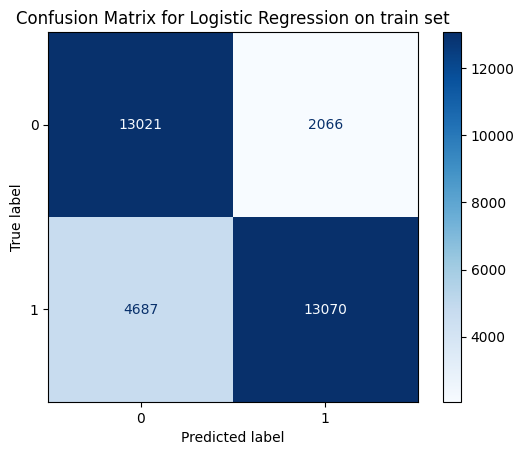

Confusion Matrix:
 [[13021  2066]
 [ 4687 13070]]
Logistic Regression Training Accuracy On Training Set: 0.79439
Performance on Original Data
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7585
           1       0.86      0.73      0.79      8925

    accuracy                           0.79     16510
   macro avg       0.80      0.80      0.79     16510
weighted avg       0.81      0.79      0.79     16510

Logistic Regression Training Accuracy On Validation Set: 0.79449



Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7585
           1       0.86      0.73      0.79      8925

    accuracy                           0.79     16510
   macro avg       0.80      0.80      0.79     16510
weighted avg       0.81      0.79      0.79     16510

Confusion Matrix:
[[6558 1027]
 [2366 6559]]


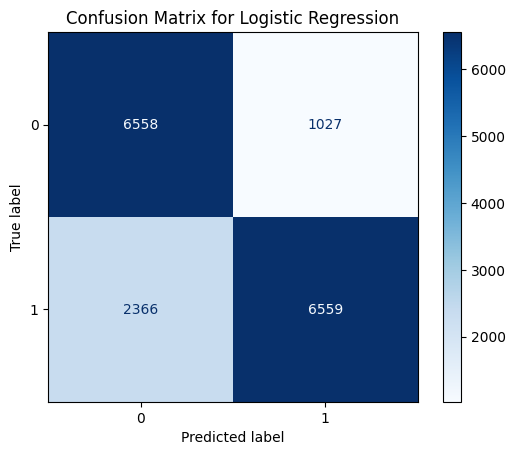

In [ ]:
# Predicting the train set results
y_pred_log_reg_train = log_reg_model.predict(X_train)

# Creating the confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred_log_reg_train)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg_model.classes_)
disp1.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression on train set")
plt.show()

# Printing the confusion matrix
print("Confusion Matrix:\n", conf_matrix)
accuracy_log_train = accuracy_score(y_train , y_pred_log_reg_train)
print(f"Logistic Regression Training Accuracy On Training Set: {accuracy_log_train:.5f}")

# Vaildation Set
validation_log_reg_model = LogisticRegression(random_state = 10, max_iter=1000)
validation_log_reg_model.fit(X_train, y_train)

# Predict on the validation set
y_pred_val = validation_log_reg_model.predict(X_val)

print("Performance on Original Data")
print(classification_report(y_val, y_pred_val))
print(f"Logistic Regression Training Accuracy On Validation Set: {accuracy_score(y_val, y_pred_val):.5f}\n\n\n")

# Calculate the accuracy
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
report = classification_report(y_val, y_pred_val)
print("Classification Report:")
print(report)

# Generate a confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

# Plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=validation_log_reg_model.classes_)
disp.plot(cmap = plt.cm.Blues)
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

# 5. Predictions

In [ ]:
#Predict using Logistic Regression
y_pred_logistic = log_reg_model.predict(X_test)

# # Predict using K-NN
# y_pred_knn = knn_model.predict(X_test)

# # Predict using Random Forest
# y_pred_rf = rf_model.predict(X_test)

# # Predict using AdaBoost
# y_pred_adaboost = ada_model.predict(X_test)

# Save predictions to a CSV file
predictions = pd.DataFrame({
    'ID': test_ids,
    'Logistic_Regression': y_pred_logistic
    # 'K-NN': y_pred_knn,
    # 'Random_Forest': y_pred_rf,
    # 'AdaBoost': y_pred_adaboost
})

predictions.to_csv('test_predictions.csv', index=False)

# Predict probabilities using Logistic Regression
prob_logistic = log_reg_model.predict_proba(X_test)

prob_logistic = prob_logistic[:, 1]


# # Predict probabilities using K-NN (Note: Ensure K-NN is set up to return probabilities)
# prob_knn = knn_model.predict_proba(X_test)

# # Predict probabilities using Random Forest
# prob_rf = rf_model.predict_proba(X_test)

# # Predict probabilities using AdaBoost
# prob_adaboost = ada_model.predict_proba(X_test)

# Assuming the positive class is the second column (index 1)
# prob_knn_pos = prob_knn[:, 1]
# prob_rf_pos = prob_rf[:, 1]
# prob_adaboost_pos = prob_adaboost[:, 1]

# Create a DataFrame with the probabilities
probabilities = pd.DataFrame({
    'ID': test_ids,
    'Logistic_Regression_Pos_Class': prob_logistic
    # 'K-NN_Pos_Class': prob_knn_pos,
    # 'Random_Forest_Pos_Class': prob_rf_pos,
    # 'AdaBoost_Pos_Class': prob_adaboost_pos
})

# Save to CSV
probabilities.to_csv('test_probabilities.csv', index=False)

# 6. Not part of course
We used the WordCloud library which allows a graphical way of seeing distribution of data.
It shows each country's name relative size - so countries with more candidates appear in bigger font.
In our example we viewed the most common countries by the size of the country's name.
This helped us get a grasp on the distribution of countries of candidates.

# Pipeline

<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]
<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]
<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]
<ipython-input-4-b8e752b32d9e>:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = data[~outliers[col]]


Ranges of numerical columns before normalization:
     years_of_experience          A     B           D  prev_salary
min                  0.0 -12.661559   0.0  176.624445          1.0
max                 39.0  20.161337  25.0  182.543172     196641.0
Data needs normalization. Applying min-max scaling...
Ranges of numerical columns after normalization:
     years_of_experience    A    B    D  prev_salary
min                  0.0  0.0  0.0  0.0          0.0
max                  1.0  1.0  1.0  1.0          1.0


<ipython-input-7-c11090b9fc5c>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[language] = data['stack_experience'].apply(lambda x: 1 if language in x.split(';') else 0)
<ipython-input-7-c11090b9fc5c>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[language] = data['stack_experience'].apply(lambda x: 1 if language in x.split(';') else 0)
<ipython-input-7-c11090b9fc5c>:40: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

Ranges of numerical columns before normalization:
     years_of_experience          A     B           D  prev_salary
min                  0.0 -12.634070   0.0  176.590043          1.0
max                 39.0  20.174409  25.0  182.574630     196400.0
Data needs normalization. Applying min-max scaling...
Ranges of numerical columns after normalization:
     years_of_experience    A    B    D  prev_salary
min                  0.0  0.0  0.0  0.0          0.0
max                  1.0  1.0  1.0  1.0          1.0


<ipython-input-7-c11090b9fc5c>:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[language] = data['stack_experience'].apply(lambda x: 1 if language in x.split(';') else 0)
<ipython-input-7-c11090b9fc5c>:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[language] = data['stack_experience'].apply(lambda x: 1 if language in x.split(';') else 0)
<ipython-input-7-c11090b9fc5c>:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

Number of features: 60
Original shape: (50796, 60)
Reduced shape: (50796, 48)
Reduced number of features after PCA: 48
Number of features: 60
Original shape: (16510, 60)
Reduced shape: (16510, 48)
Reduced number of features after PCA: 48
Done with Preprocessing and ready for Model Training and Predictions
Accuracy: 0.79231
AUC Score: 0.91348
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7499
           1       0.86      0.74      0.80      9011

    accuracy                           0.79     16510
   macro avg       0.80      0.80      0.79     16510
weighted avg       0.80      0.79      0.79     16510

Confusion Matrix:
[[6430 1069]
 [2360 6651]]


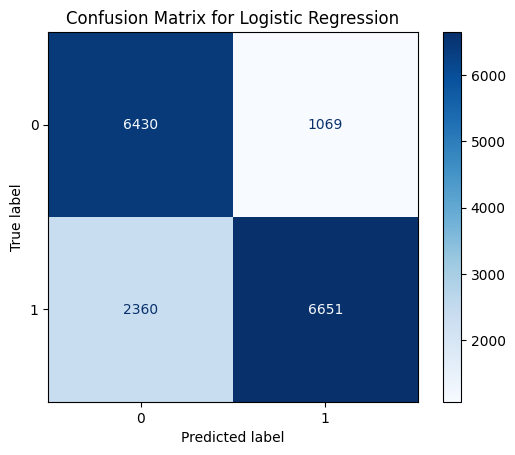

Confusion Matrix:
 [[6430 1069]
 [2360 6651]]


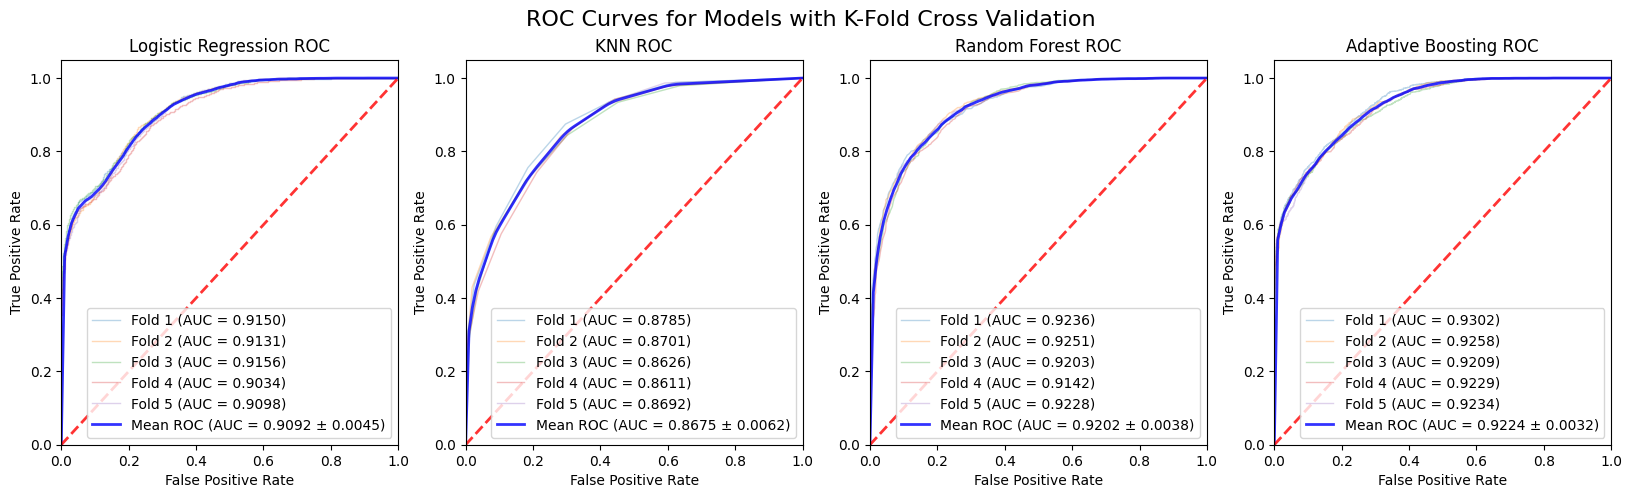

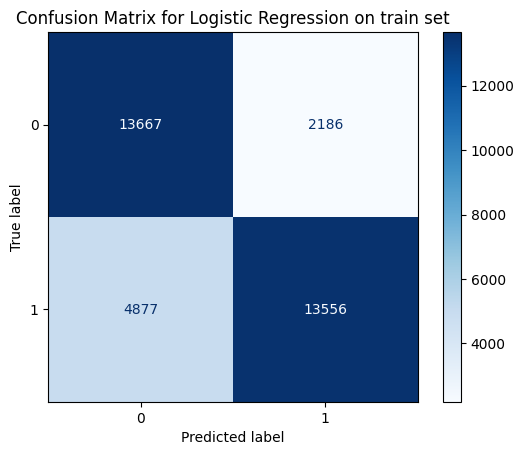

Confusion Matrix:
 [[13667  2186]
 [ 4877 13556]]
Logistic Regression Training Accuracy On Training Set: 0.79400
Performance on Original Data
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7499
           1       0.86      0.74      0.80      9011

    accuracy                           0.79     16510
   macro avg       0.80      0.80      0.79     16510
weighted avg       0.80      0.79      0.79     16510

Logistic Regression Training Accuracy On Validation Set: 0.79231



Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.86      0.79      7499
           1       0.86      0.74      0.80      9011

    accuracy                           0.79     16510
   macro avg       0.80      0.80      0.79     16510
weighted avg       0.80      0.79      0.79     16510

Confusion Matrix:
[[6430 1069]
 [2360 6651]]


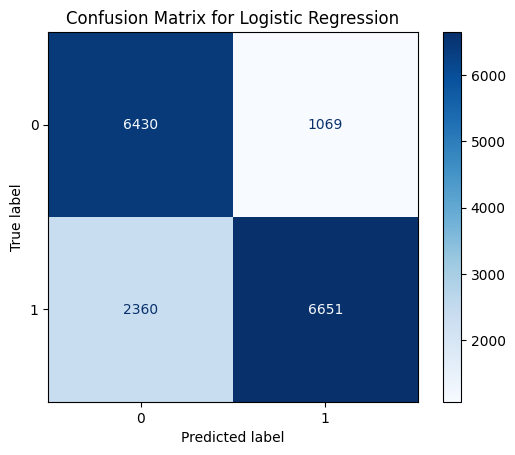

Done with Preprocessing and Model Training, ready for Predictions
Done with Preprocessing, Model Training and Predictions


In [ ]:
#pipeline
def pipeline(train_data_path, new_data_path):
    # # read the train data
    train_data = pd.read_csv(train_data_path)
    # # read the test data
    new_data = pd.read_csv(new_data_path)

    all_cols = train_data.columns
    columns_to_exclude_train = ['ID', 'label']  # columns to exclude from train set
    #columns_to_exclude_new = ['ID']  # columns to exclude from new set
    # Drop the specified columns
    data_filtered_train = train_data.drop(columns=columns_to_exclude_train)
    #data_filtered_test = new_data.drop(columns=columns_to_exclude_test)

    # Seperate numeric and categorial columns for exploration
    numeric_cols = data_filtered.select_dtypes(include=np.number).columns
    numeric_data = data_filtered[numeric_cols]
    categorical_cols= list(set(all_cols) - set(numeric_cols))

    # # Apply preprocessing on train data set
    train_data = deal_with_outliers(train_data) #dealing wiht outliers
    train_data = data_normalization(train_data) #normalizing num data
    train_data = handle_missing_data(train_data) #handling missing data
    train_data = handle_categorial_variables(train_data)  #handling categorial variables
    train_data = normalize_data_categorial(train_data)  #normalize again after handling categorial variables

    # # Apply preprocessing on new data set
    new_data, new_data_ids = preprocess_test_set(new_data) # Apply preprocessing on new data set

    # # turn data to numpy
    X = train_data.to_numpy()
    X = X[:, :-1]
    y = train_data['label'].to_numpy()
    X_new = new_data.to_numpy()

    # # Apply dimensionality PCA to datasets
    X = dimensionality_and_pca(X)
    X_new = dimensionality_and_pca(X_new)

    print("Done with Preprocessing and ready for Model Training and Predictions")

    # # # MODEL Training
    # # Logistic Regression
    # Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=len(X_new), random_state=42)

    log_reg_model = LogisticRegression(random_state=42)

    # Train the model on the training data
    log_reg_model.fit(X_train, y_train)

    #Predict on the validation set
    y_val_pred = log_reg_model.predict(X_val)

    # Calculate the accuracy
    accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Accuracy: {accuracy:.5f}")

    # Predict probabilities for the validation set
    y_val_prob = log_reg_model.predict_proba(X_val)[:, 1]

    # Calculate the AUC score
    auc_log = roc_auc_score(y_val, y_val_prob)
    print(f"AUC Score: {auc_log:.5f}")

    # Generate a classification report
    report = classification_report(y_val, y_val_pred)
    print("Classification Report:")
    print(report)

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    print("Confusion Matrix:")
    print(conf_matrix)

    # # # Model Evaluation
    # # Confution matrix
    # Predicting the test set results
    y_pred = log_reg_model.predict(X_val)

    # Creating the confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred)

    # Plot the confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg_model.classes_)
    disp.plot(cmap = plt.cm.Blues)
    plt.title("Confusion Matrix for Logistic Regression")
    plt.show()

    # Printing the confusion matrix
    print("Confusion Matrix:\n", conf_matrix)

    # # Cross Fold-K Validation
    # Number of splits for K-Fold
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize plots
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))

    models = {
        'Logistic Regression': log_reg_model,
        'KNN': knn_model,
        'Random Forest': rf_model,
        'Adaptive Boosting': ada_model
    }

    # Loop over each model
    for i, (model_name, model) in enumerate(models.items()):
        mean_fpr = np.linspace(0, 1, 100)
        tprs = []
        aucs = []

        # Loop over each fold
        for fold, (train_index, test_index) in enumerate(kf.split(X_val , y_val)):
            X_train_fold, X_test_fold = X[train_index], X[test_index]
            y_train_fold, y_test_fold = y[train_index], y[test_index]

            # Train the model
            model.fit(X_train_fold, y_train_fold)

            # Get the probability estimates for the positive class
            y_prob = model.predict_proba(X_test_fold)[:, 1]

            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test_fold, y_prob)
            roc_auc = auc(fpr, tpr)

            # Interpolate the ROC curve to get a mean curve across folds
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(roc_auc)

            # Plot ROC curve for the current fold
            ax[i].plot(fpr, tpr, lw=1, alpha=0.3, label=f'Fold {fold + 1} (AUC = {roc_auc:.4f})')

        # Plot the mean ROC curve across folds
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        ax[i].plot(mean_fpr, mean_tpr, color='b',
                    label=f'Mean ROC (AUC = {mean_auc:.4f} ± {std_auc:.4f})',
                    lw=2, alpha=0.8)

        # Plot the chance line (diagonal)
        ax[i].plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)
        ax[i].set_xlim([0.0, 1.0])
        ax[i].set_ylim([0.0, 1.05])
        ax[i].set_xlabel('False Positive Rate')
        ax[i].set_ylabel('True Positive Rate')
        ax[i].set_title(f'{model_name} ROC')
        ax[i].legend(loc='lower right')

    plt.suptitle('ROC Curves for Models with K-Fold Cross Validation', fontsize=16)
    plt.show()

    # # Performance Gaps
    # Predicting the train set results
    y_pred_log_reg_train = log_reg_model.predict(X_train)

    # Creating the confusion matrix
    conf_matrix = confusion_matrix(y_train, y_pred_log_reg_train)

    # Plot the confusion matrix using ConfusionMatrixDisplay
    disp1 = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=log_reg_model.classes_)
    disp1.plot(cmap = plt.cm.Blues)
    plt.title("Confusion Matrix for Logistic Regression on train set")
    plt.show()

    # Printing the confusion matrix
    print("Confusion Matrix:\n", conf_matrix)
    accuracy_log_train = accuracy_score(y_train , y_pred_log_reg_train)
    print(f"Logistic Regression Training Accuracy On Training Set: {accuracy_log_train:.5f}")

    # Vaildation Set
    validation_log_reg_model = LogisticRegression(random_state = 10, max_iter=1000)
    validation_log_reg_model.fit(X_train, y_train)

    # Predict on the validation set
    y_pred_val = validation_log_reg_model.predict(X_val)

    print("Performance on Original Data")
    print(classification_report(y_val, y_pred_val))
    print(f"Logistic Regression Training Accuracy On Validation Set: {accuracy_score(y_val, y_pred_val):.5f}\n\n\n")

    # Calculate the accuracy
    accuracy = accuracy_score(y_val, y_pred_val)
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    report = classification_report(y_val, y_pred_val)
    print("Classification Report:")
    print(report)

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(y_val, y_pred_val)
    print("Confusion Matrix:")
    print(conf_matrix)

    # Plot the confusion matrix using ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=validation_log_reg_model.classes_)
    disp.plot(cmap = plt.cm.Blues)
    plt.title("Confusion Matrix for Logistic Regression")
    plt.show()

    print("Done with Preprocessing and Model Training, ready for Predictions")

    # # # Predictions
    #Predict using Logistic Regression
    y_pred_logistic = log_reg_model.predict(X_test)

    # Save predictions to a CSV file
    predictions = pd.DataFrame({
        'ID': test_ids,
        'Logistic_Regression': y_pred_logistic
        # 'K-NN': y_pred_knn,
        # 'Random_Forest': y_pred_rf,
        # 'AdaBoost': y_pred_adaboost
    })

    predictions.to_csv('test_predictions.csv', index=False)

    # Predict probabilities using Logistic Regression
    prob_logistic = log_reg_model.predict_proba(X_test)

    prob_logistic = prob_logistic[:, 1]

    # Create a DataFrame with the probabilities
    probabilities = pd.DataFrame({
        'ID': test_ids,
        'Logistic_Regression_Pos_Class': prob_logistic
        # 'K-NN_Pos_Class': prob_knn_pos,
        # 'Random_Forest_Pos_Class': prob_rf_pos,
        # 'AdaBoost_Pos_Class': prob_adaboost_pos
    })

    # Save to CSV
    probabilities.to_csv('test_probabilities.csv', index=False)

    print("Done with Preprocessing, Model Training and Predictions")

pipeline('train.csv', 'test.csv')

# Unused

In [ ]:
# # Identify categorical columns
# # Assuming 'education' could be an ordinal variable
# ordinal_columns = ['education', 'country', 'stack_experience', 'C' ]
# for col in ordinal_columns:
#     if col in data.columns:
#         data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# # Categorical columns excluding ordinal columns
# categorical_cols = [col for col in categorical_cols if col not in ordinal_columns]

# # Define features and target
# X_train = data.drop(columns = ['label'])  # Replace 'label' with your target column name
# y_train = data['label']

# # Fit OneHotEncoder on training data
# encoder = OneHotEncoder(drop = 'first', sparse=False)
# encoder.fit(X_train[categorical_cols])

# # Transform the training set
# X_train_encoded = encoder.transform(X_train[categorical_cols])

# # Convert the encoded arrays back to DataFrames
# encoded_cols = encoder.get_feature_names_out(categorical_cols)
# X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)

# # Drop original categorical columns and concatenate the encoded columns
# X_train = X_train.drop(columns=categorical_cols).join(X_train_encoded_df)
# X_train

#UNUSED

# contains Duplicate code
# Load the training dataset
# train_file_path = 'train.csv'
# train_data = pd.read_csv(train_file_path)

# # Handle missing data
# def handle_missing_data(df):
#     for col in df.columns:
#         if df[col].isnull().sum() > 0:
#             if df[col].dtype == 'object':
#                 df[col].fillna(df[col].mode()[0], inplace=True)
#             else:
#                 df[col].fillna(df[col].mean(), inplace=True)
#     return df

# train_data = handle_missing_data(train_data)

# # Identify categorical columns
# categorical_cols = train_data.select_dtypes(include=['object']).columns.tolist()

# # Assuming 'education' could be an ordinal variable
# ordinal_columns = ['education']
# for col in ordinal_columns:
#     if col in train_data.columns:
#         train_data[col] = LabelEncoder().fit_transform(train_data[col].astype(str))

# # Categorical columns excluding ordinal columns
# categorical_cols = [col for col in categorical_cols if col not in ordinal_columns]

# # Define features and target
# X_train = train_data.drop(columns=['label'])  # Replace 'label' with your target column name
# y_train = train_data['label']

# # Fit OneHotEncoder on training data
# encoder = OneHotEncoder(drop='first', sparse=False)
# encoder.fit(X_train[categorical_cols])

# # Transform the training set
# X_train_encoded = encoder.transform(X_train[categorical_cols])

# # Convert the encoded arrays back to DataFrames
# encoded_cols = encoder.get_feature_names_out(categorical_cols)
# X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)

# # Drop original categorical columns and concatenate the encoded columns
# X_train = X_train.drop(columns=categorical_cols).join(X_train_encoded_df)

# # Scaling
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)

# # Train and evaluate KNN model without PCA
# knn_model_no_pca = KNeighborsClassifier(n_neighbors=5)
# knn_model_no_pca.fit(X_train_scaled, y_train)

# # Train and evaluate Logistic Regression model without PCA
# log_reg_model_no_pca = LogisticRegression(random_state=42, max_iter=1000)
# log_reg_model_no_pca.fit(X_train_scaled, y_train)

#----------------------
#----------------------


# Load the test dataset
# test_file_path = 'test.csv'  # Replace with the actual test file path
# test_data = pd.read_csv(test_file_path)

# # Handle missing data
# test_data = handle_missing_data(test_data)

# # Identify categorical columns in the test data
# categorical_cols_test = test_data.select_dtypes(include=['object']).columns.tolist()

# # Transform the test set using the same OneHotEncoder
# X_test_encoded = encoder.transform(test_data[categorical_cols_test])

# # Convert the encoded arrays back to DataFrames
# X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_cols_test), index=test_data.index)

# # Drop original categorical columns and concatenate the encoded columns
# X_test = test_data.drop(columns=categorical_cols_test).join(X_test_encoded_df)

# # Scaling
# X_test_scaled = scaler.transform(X_test)

# # Predict and evaluate models without PCA
# y_pred_knn_no_pca = knn_model_no_pca.predict(X_test_scaled)
# y_pred_log_reg_no_pca = log_reg_model_no_pca.predict(X_test_scaled)

# # Evaluate accuracy
# accuracy_knn_no_pca = accuracy_score(y_train, knn_model_no_pca.predict(X_train_scaled))
# accuracy_log_reg_no_pca = accuracy_score(y_train, log_reg_model_no_pca.predict(X_train_scaled))
# print(f"KNN Accuracy without PCA: {accuracy_knn_no_pca}")
# print(f"Logistic Regression Accuracy without PCA: {accuracy_log_reg_no_pca}")

# # Save test set predictions without PCA
# predictions_no_pca = pd.DataFrame({
#     'KNN': y_pred_knn_no_pca,
#     'LogisticRegression': y_pred_log_reg_no_pca
# })
# predictions_no_pca.to_csv('test_predictions_no_pca.csv', index=False)
